# Step 1: Importing the modules

In [36]:
# TensorFlow is an open source machine learning library
!pip install tensorflow==2.0
import tensorflow as tf
# NumPy is a math library
import numpy as np
# Matplotlib is a graphing library
import matplotlib.pyplot as plt
# math is Python's math library
import math

In [0]:
from keras.models import Sequential
from keras.layers import Dense 
from tensorflow.keras import layers
import numpy

In [0]:
seed = 9
numpy.random.seed(seed)

In [0]:
from pandas import read_csv

In [0]:

filename = '/content/PlantGrowth.csv'
dataframe = read_csv(filename)

In [0]:
array = dataframe.values

In [62]:
X = array[:,0]
Y = array[:,1]
print(X)
print(Y)

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.  ]
[0.0662142  0.14246659 0.17907828 0.25533067 0.29194236 0.36819474
 0.42462678 0.48105882 0.51767051 0.5939229  0.65035494 0.68696663
 0.74339867 0.81965105 0.85626274 0.93251513 0.96912682 1.04537921
 1.0453     1.00622   ]


In [63]:
dataframe.head()

,Days,Plant Height
0,0.05,0.066214
1,0.10,0.142467
2,0.15,0.179078
3,0.20,0.255331
4,0.25,0.291942


In [0]:
import tensorflow as tf

In [80]:
model = tf.keras.Sequential()
# First layer takes a scalar input and feeds it through 16 "neurons." The
# neurons decide whether to activate based on the 'relu' activation function.
model.add(layers.Dense(16, activation='relu',input_shape=(1,)))
# The new second layer may help the network learn more complex representations
model.add(layers.Dense(16, activation='relu'))
# Final layer is a single neuron, since we want to output a single value
model.add(layers.Dense(1,activation='sigmoid'))
# Compile the model using a standard optimizer and loss function for regression
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
# Show a summary of the model
model.summary()


Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_36 (Dense)             (None, 16)                32        
_________________________________________________________________
dense_37 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_38 (Dense)             (None, 1)                 17        
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [81]:
history = model.fit(X,Y,epochs=400,batch_size=10)

Train on 20 samples
Epoch 1/400
20/20 [==============================] - 0s 20ms/sample - loss: 0.1126 - mae: 0.2882
Epoch 2/400
20/20 [==============================] - 0s 417us/sample - loss: 0.1108 - mae: 0.2868
Epoch 3/400
20/20 [==============================] - 0s 392us/sample - loss: 0.1092 - mae: 0.2846
Epoch 4/400
20/20 [==============================] - 0s 324us/sample - loss: 0.1078 - mae: 0.2833
Epoch 5/400
20/20 [==============================] - 0s 381us/sample - loss: 0.1065 - mae: 0.2815
Epoch 6/400
20/20 [==============================] - 0s 367us/sample - loss: 0.1054 - mae: 0.2800
Epoch 7/400
20/20 [==============================] - 0s 314us/sample - loss: 0.1044 - mae: 0.2787
Epoch 8/400
20/20 [==============================] - 0s 357us/sample - loss: 0.1034 - mae: 0.2776
Epoch 9/400
20/20 [==============================] - 0s 302us/sample - loss: 0.1027 - mae: 0.2768
Epoch 10/400
20/20 [==============================] - 0s 342us/sample - loss: 0.1021 - mae: 0.2760


In [82]:
score=model.evaluate(X,Y)
#print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

20/1 [========================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================] - 0s 3ms/sample - loss: 0.0019 - mae: 0.0351


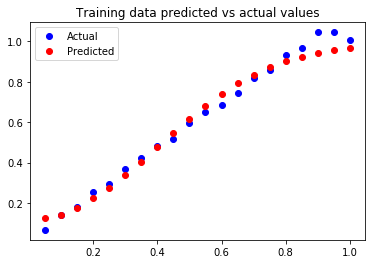

In [85]:
predictions = model.predict(X)

# Plot the predictions along with to the test data
plt.clf()
plt.title('Training data predicted vs actual values')
plt.plot(X, Y, 'bo', label='Actual')
plt.plot(X, predictions, 'ro', label='Predicted')
plt.legend()
plt.show()

In [86]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model to disk
open("growth_model.tflite", "wb").write(tflite_model)

# Convert the model to the TensorFlow Lite format with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.OPTIMIZE_FOR_SIZE]
tflite_model = converter.convert()

# Save the model to disk
open("growth_model_quantized.tflite", "wb").write(tflite_model)

2864

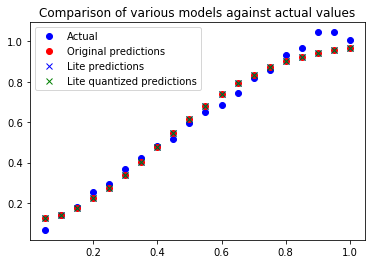

In [87]:
growth_model = tf.lite.Interpreter('growth_model.tflite')
growth_model_quantized = tf.lite.Interpreter('growth_model_quantized.tflite')

# Allocate memory for each model
growth_model.allocate_tensors()
growth_model_quantized.allocate_tensors()

# Get the input and output tensors so we can feed in values and get the results
growth_model_input = growth_model.tensor(growth_model.get_input_details()[0]["index"])
growth_model_output = growth_model.tensor(growth_model.get_output_details()[0]["index"])
growth_model_quantized_input = growth_model_quantized.tensor(growth_model_quantized.get_input_details()[0]["index"])
growth_model_quantized_output = growth_model_quantized.tensor(growth_model_quantized.get_output_details()[0]["index"])

# Create arrays to store the results
growth_model_predictions = np.empty(X.size)
growth_model_quantized_predictions = np.empty(X.size)

# Run each model's interpreter for each value and store the results in arrays
for i in range(X.size):
  growth_model_input().fill(X[i])
  growth_model.invoke()
  growth_model_predictions[i] = growth_model_output()[0]

  growth_model_quantized_input().fill(X[i])
  growth_model_quantized.invoke()
  growth_model_quantized_predictions[i] = growth_model_quantized_output()[0]

# See how they line up with the data
plt.clf()
plt.title('Comparison of various models against actual values')
plt.plot(X, Y, 'bo', label='Actual')
plt.plot(X, predictions, 'ro', label='Original predictions')
plt.plot(X, growth_model_predictions, 'bx', label='Lite predictions')
plt.plot(X, growth_model_quantized_predictions, 'gx', label='Lite quantized predictions')
plt.legend()
plt.show()

In [88]:
import os
basic_model_size = os.path.getsize("growth_model.tflite")
print("Basic model is %d bytes" % basic_model_size)
quantized_model_size = os.path.getsize("growth_model_quantized.tflite")
print("Quantized model is %d bytes" % quantized_model_size)
difference = basic_model_size - quantized_model_size
print("Difference is %d bytes" % difference)


Basic model is 2896 bytes
Quantized model is 2864 bytes
Difference is 32 bytes


In [90]:
# Install xxd if it is not available
!apt-get -qq install xxd
# Save the file as a C source file
!xxd -i growth_model_quantized.tflite > growth_model_quantized.cc
# Print the source file
!cat growth_model_quantized.cc

unsigned char growth_model_quantized_tflite[] = {
  0x1c, 0x00, 0x00, 0x00, 0x54, 0x46, 0x4c, 0x33, 0x00, 0x00, 0x12, 0x00,
  0x1c, 0x00, 0x04, 0x00, 0x08, 0x00, 0x0c, 0x00, 0x10, 0x00, 0x14, 0x00,
  0x00, 0x00, 0x18, 0x00, 0x12, 0x00, 0x00, 0x00, 0x03, 0x00, 0x00, 0x00,
  0xdc, 0x0a, 0x00, 0x00, 0x08, 0x06, 0x00, 0x00, 0xf0, 0x05, 0x00, 0x00,
  0x34, 0x00, 0x00, 0x00, 0x04, 0x00, 0x00, 0x00, 0x01, 0x00, 0x00, 0x00,
  0x04, 0x00, 0x00, 0x00, 0xcc, 0xf5, 0xff, 0xff, 0x08, 0x00, 0x00, 0x00,
  0x0c, 0x00, 0x00, 0x00, 0x13, 0x00, 0x00, 0x00, 0x6d, 0x69, 0x6e, 0x5f,
  0x72, 0x75, 0x6e, 0x74, 0x69, 0x6d, 0x65, 0x5f, 0x76, 0x65, 0x72, 0x73,
  0x69, 0x6f, 0x6e, 0x00, 0x0d, 0x00, 0x00, 0x00, 0xb0, 0x05, 0x00, 0x00,
  0x60, 0x05, 0x00, 0x00, 0x08, 0x05, 0x00, 0x00, 0xb8, 0x04, 0x00, 0x00,
  0xb0, 0x04, 0x00, 0x00, 0xa8, 0x04, 0x00, 0x00, 0xa0, 0x04, 0x00, 0x00,
  0x98, 0x04, 0x00, 0x00, 0x88, 0x00, 0x00, 0x00, 0x80, 0x00, 0x00, 0x00,
  0x6c, 0x00, 0x00, 0x00, 0x1c, 0x00, 0x00, 0x00, 0x04, 0x00, 